In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [3]:
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


----------------------

In [4]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'AOcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'GAgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [5]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 78 
 gambiae samples: 69


In [6]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [7]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [8]:
del ann

In [9]:
#Changed from GenotypeDaskArray to GenotypeChunkedArray
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [10]:
# bool biallelic and in genes
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [11]:
#filter to get only biallelic in genes
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [12]:
# get just bf coluzzii individuals
random_index = random.sample(index_m, 69)
gm = {chrom: ga[chrom].take(random_index, axis=1) for chrom in contigs}

In [13]:
#take an equal number of samples
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [14]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [15]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [16]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 886203
seg sites coluzii chrom 3R: 1183864
seg sites coluzii chrom 2R: 1241703
seg sites coluzii chrom 2L: 949291
seg sites coluzii chrom X: 347431


In [17]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 1146616
seg sites gambiae chrom 3R: 1635111
seg sites gambiae chrom 2R: 1752127
seg sites gambiae chrom 2L: 1195164
seg sites gambiae chrom X: 369285


In [18]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [19]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [20]:
outgroups = ['epir', 'chri', 'meru', 'mela']

In [21]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [22]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [23]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [24]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [25]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [26]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [27]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [28]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}

alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [29]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [30]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom][bool_aa_match[chrom]]
    alt[chrom] = alt_bial_genes[chrom][bool_aa_match[chrom]]
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom][bool_aa_match[chrom]]
    pos_bial_genes[chrom] = pos_bial_genes[chrom][bool_aa_match[chrom]]
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom][bool_aa_match[chrom]]

In [31]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [32]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [33]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [34]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [35]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [36]:
chrom = 'X'
assert(af_gambiae_novar_out[chrom].shape[0] == af_gambiae_novar_out[chrom].shape[0] == pos_bial_genes[chrom].shape[0])

## Sanity Check

In [37]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([ 9469040, 16556513, 17163911, 22946231, 25060879, 34883728,
       34883729, 34884498, 35725945, 35814873, 36912073, 41365173, 41775147], dtype=int32)

In [38]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([11990120, 16557333, 16558524, 16559600, 16564670, 16571269,
       25063740, 25070089, 25154529, 25166866, 35721577, 35726960,
       35813220, 35813277], dtype=int32)

In [39]:
loc_3L = np.in1d(pos_bial_genes['3L'], fixed_c['3L'])
np.compress(loc_3L, af_coluzzii_novar_out['3L'], axis=0)[:10]

array([[ 0.08695652,  0.91304348],
       [ 0.97826087,  0.02173913],
       [ 0.97101449,  0.02898551],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.07971014,  0.92028986],
       [ 0.94202899,  0.05797101],
       [ 0.98550725,  0.01449275],
       [ 0.97101449,  0.02898551]])

In [40]:
np.compress(loc_3L, af_gambiae_novar_out['3L'], axis=0)[:10]

array([[ 0.99275362,  0.00724638],
       [ 0.03623188,  0.96376812],
       [ 0.05072464,  0.94927536],
       [ 0.06521739,  0.93478261],
       [ 0.05797101,  0.94202899],
       [ 0.0942029 ,  0.9057971 ],
       [ 1.        ,  0.        ],
       [ 0.01449275,  0.98550725],
       [ 0.07971014,  0.92028986],
       [ 0.06521739,  0.93478261]])

In [41]:
np.compress(loc_3L, af_novar_out['chri']['3L'], axis=0)[:10,:2]

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

-----------------------------

## Stat

In [42]:
def identify_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    return interval_join

In [43]:
identify_fixex_coluzzii = {chrom: identify_variants_per_gene(chrom, fixed_c, 'coluzzii_segreg') for chrom in contigs}

In [44]:
identify_fixex_gambiae = {chrom: identify_variants_per_gene(chrom, fixed_g, 'coluzzii_segreg') for chrom in contigs}

In [45]:
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [46]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [47]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [48]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [49]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [50]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [51]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [52]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [53]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001410,1,410,410.0
AGAP001658,2,224,112.0
AGAP001672,2,332,166.0
AGAP001674,10,667,66.7
AGAP001675,1,40,40.0


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001201,1,1932,1932.0
AGAP001632,1,195,195.0
AGAP001658,1,405,405.0
AGAP001674,1,1186,1186.0
AGAP001683,15,6707,447.1333333333333


In [54]:
etl.rowlengths(joi_seg_fix_gambiae['X'])

length,count
4,64


In [55]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [56]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  177424.0 
 C genome wide:  1462.0 
 A/C genome wide:  121.35704514363886

 B genome wide:  209950.0 
 D genome wide:  566.0 
 B/D genome wide:  370.9363957597173


In [57]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [58]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [59]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [60]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [61]:
with open('/home/randomx/hka/gambiae_hka_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [62]:
with open('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


------------------------------------------------------------

In [63]:
hka_gambiae = etl.fromtsv('/home/randomx/hka/gambiae_hka_summary_beta.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP011379,8673,1,5.2009160459
3R,AGAP007735,17,2,9.83076832967
3R,AGAP007731,89,2,1.95079463057
3R,AGAP007736,1072,38,82.8352794949
3R,AGAP007762,45,3,10.3597680222
3R,AGAP007732,266,8,14.3278667994
3R,AGAP009725,2919,1,1.62883532293
3R,AGAP007754,120,5,12.0941601313
3R,AGAP007761,405,7,6.46441394291
2R,AGAP004228,2722,1,1.50088836023


In [64]:
hka_coluzzii = etl.fromtsv('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP011094,113,1,0.184924454108
3L,AGAP011479,367,2,0.11568761928
3R,AGAP007763,10,1,0.770029766628
3R,AGAP007735,10,1,0.770029766628
3R,AGAP007731,33,4,8.25799606987
3R,AGAP007736,690,45,53.6880742667
3R,AGAP009683,1875,1,3.40501187047
3R,AGAP007767,28,1,0.23079098395
3R,AGAP007734,20,1,0.37024692142
3R,AGAP007732,92,20,82.8885689414


In [65]:
hka_gambiae.convert('score_g', float).select(lambda r: (r.chrom == 'X') & (r.score_g >= 1.3)).rowlengths() 

length,count
5,23


In [66]:
hka_coluzzii.convert('score_c', float).select(lambda r: (r.chrom == 'X') & (r.score_c >= 1.3)).rowlengths() 

length,count
5,51


-----------------------------

## Distruptive selection

In [67]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.display(10)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001052,321,73,inf,374,2,0.202428530957,inf
X,AGAP001061,111,49,inf,272,7,10.4046347998,inf
X,AGAP001073,99,54,inf,192,4,4.35762428831,inf
X,AGAP001094,31,36,inf,30,2,5.83929822753,inf
X,AGAP001091,32,26,285.90830157,39,6,52.8103551144,338.7186566844
X,AGAP001093,51,32,301.756216353,62,1,0.374909621149,302.13112597414903
X,AGAP001084,78,33,237.217222292,103,7,29.1474246401,266.3646469321
X,AGAP001070,104,37,233.177272444,132,4,6.63436475106,239.81163719506
X,AGAP013021,137,42,234.855910576,168,2,0.909329376466,235.765239952466
3R,AGAP007736,690,45,53.6880742667,1072,38,82.8352794949,136.5233537616


In [68]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001061,111,49,inf,272,7,10.4046347998,inf
X,AGAP001091,32,26,285.90830157,39,6,52.8103551144,338.7186566844
X,AGAP001084,78,33,237.217222292,103,7,29.1474246401,266.3646469321
3R,AGAP007736,690,45,53.6880742667,1072,38,82.8352794949,136.5233537616
X,AGAP001092,4,4,40.6238845702,1,2,61.1938695622,101.8177541324
3R,AGAP007732,92,20,82.8885689414,266,8,14.3278667994,97.2164357408


## Indentify genes which experienced private selection

In [69]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001052,321,73,inf,374,2,0.202428530957
X,AGAP001093,51,32,301.756216353,62,1,0.374909621149
X,AGAP001069,46,28,258.607691246,None,None,0
X,AGAP013021,137,42,234.855910576,168,2,0.909329376466
X,AGAP001090,17,12,117.696038121,None,None,0
X,AGAP001065,13,10,101.746177509,None,None,0
X,AGAP001043,158,28,96.8133971019,153,2,1.02878657316
X,AGAP001083,9,7,68.9447070721,None,None,0
X,AGAP001068,18,9,68.9422821168,None,None,0
X,AGAP001082,53,14,67.7863294026,45,1,0.545919179355


In [70]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001051,None,None,0,6,2,23.1551537565
2R,AGAP004648,330,2,0.0471918551206,361,11,20.3459727528
2R,AGAP004657,9,1,0.847821958143,13,2,12.4292150686
3R,AGAP007754,None,None,0,120,5,12.0941601313
2R,AGAP001824,2054,15,0.134845692101,3408,32,11.9840660559
3R,AGAP007762,62,1,0.00736289563897,45,3,10.3597680222
3R,AGAP007735,10,1,0.770029766628,17,2,9.83076832967
2R,AGAP004637,55,1,0.0222243110746,66,3,7.09485497988
3R,AGAP007761,250,5,1.02903555732,405,7,6.46441394291
2R,AGAP002315,None,None,0,8914,1,5.3471296057


## Plot genome wide HKA

In [71]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [72]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [73]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [74]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])
    if chrom == 'X':
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 40)
    sns.despine(offset=10)

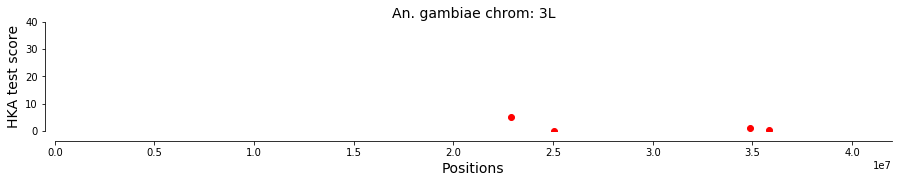

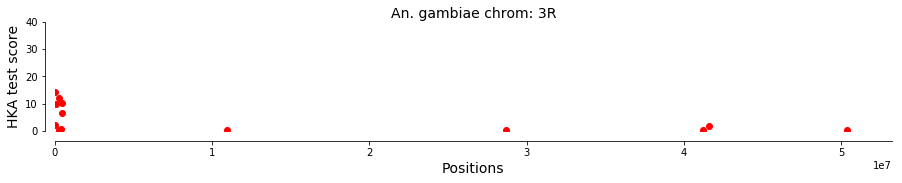

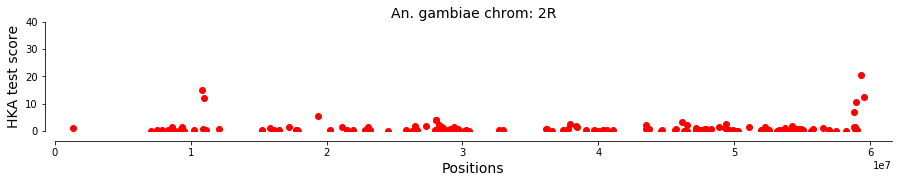

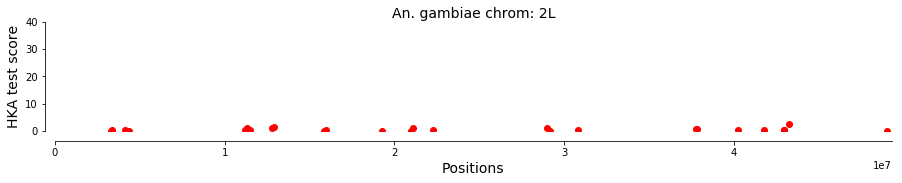

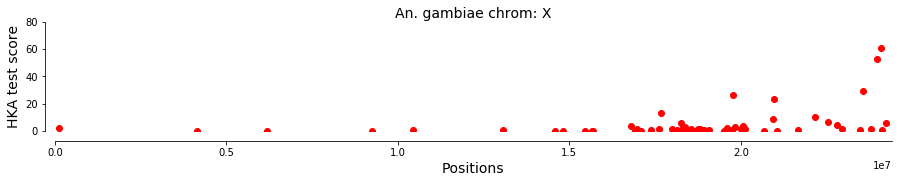

In [75]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

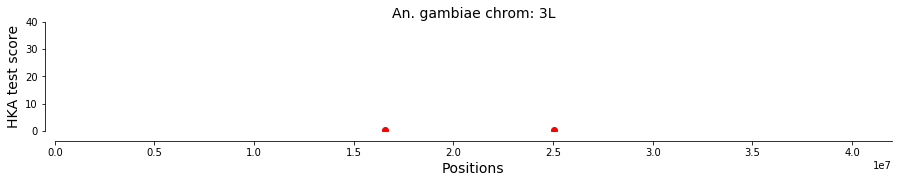

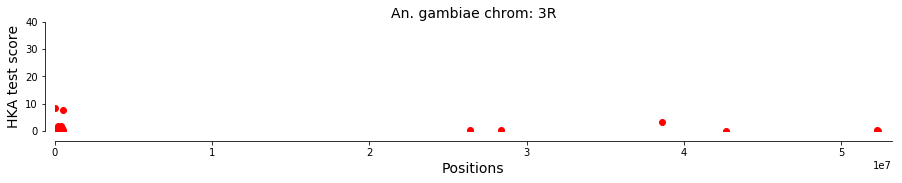

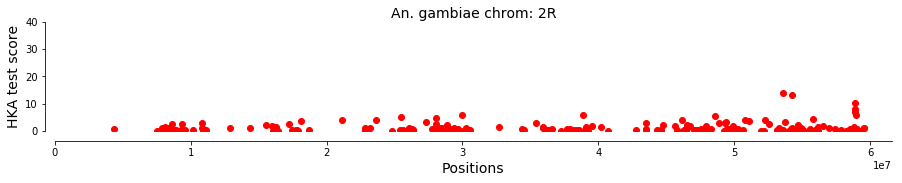

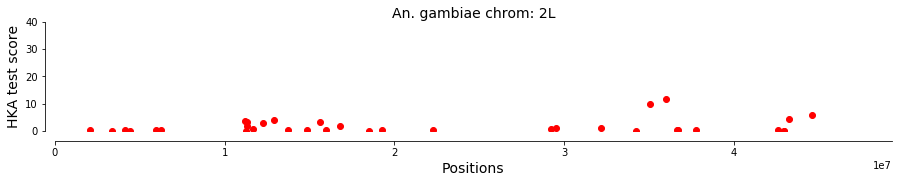

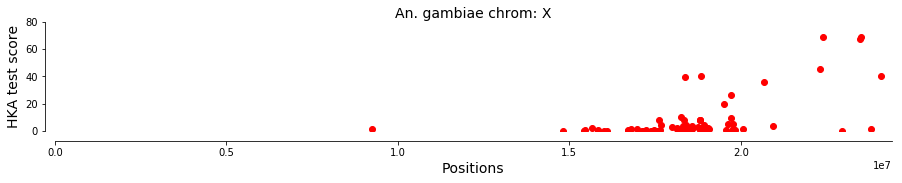

In [76]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)

## Plot seg fixed An coluzzii

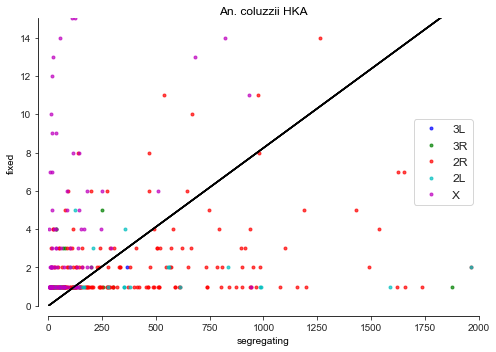

In [77]:
fig, ax = plt.subplots(figsize=(7,5))
for num, chrom in enumerate(contigs):
    
    colour = {0:'b', 1:'g', 2:'r', 3: 'c', 4:'m'}
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed,  colour[num] + '.', alpha=0.7, label=chrom)
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii], 'k')
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('An. coluzzii HKA')
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    ax.legend(loc=7, fontsize='large')
    sns.despine(offset=10)

fig.tight_layout()

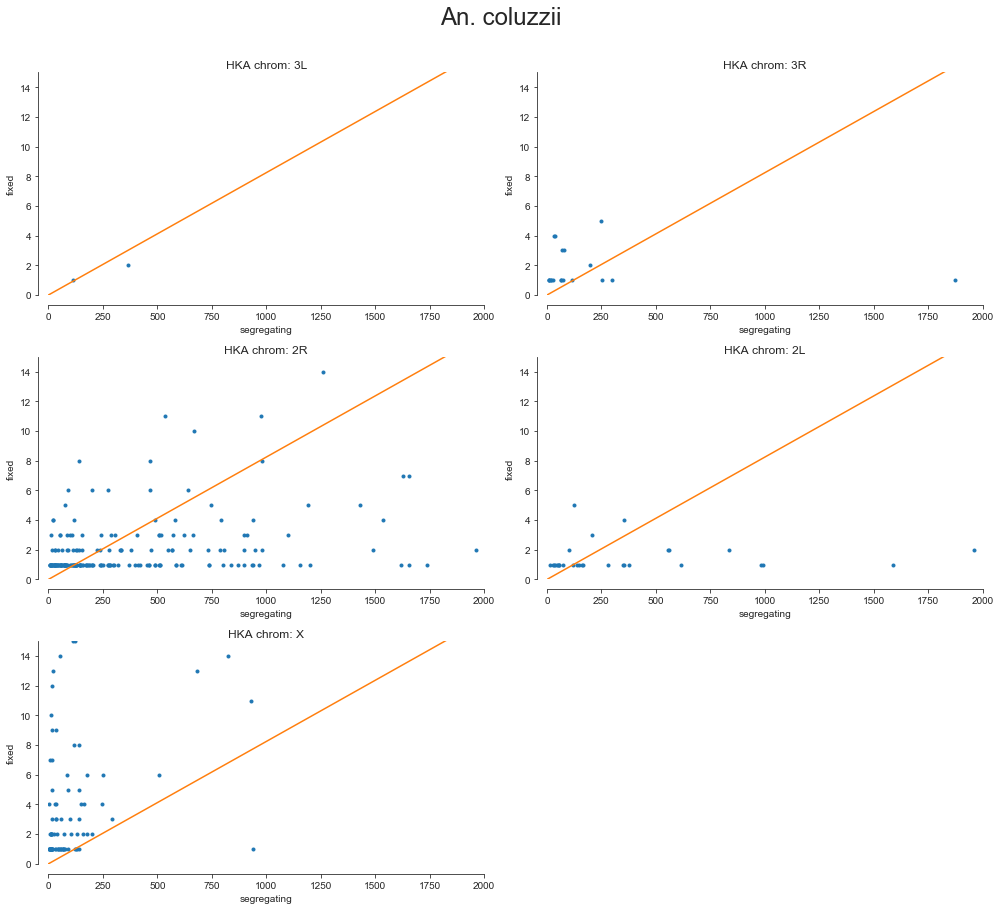

In [78]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. coluzzii', y=1.05, fontsize=24)
fig.tight_layout()

## Plot seg fixed An. gambiae

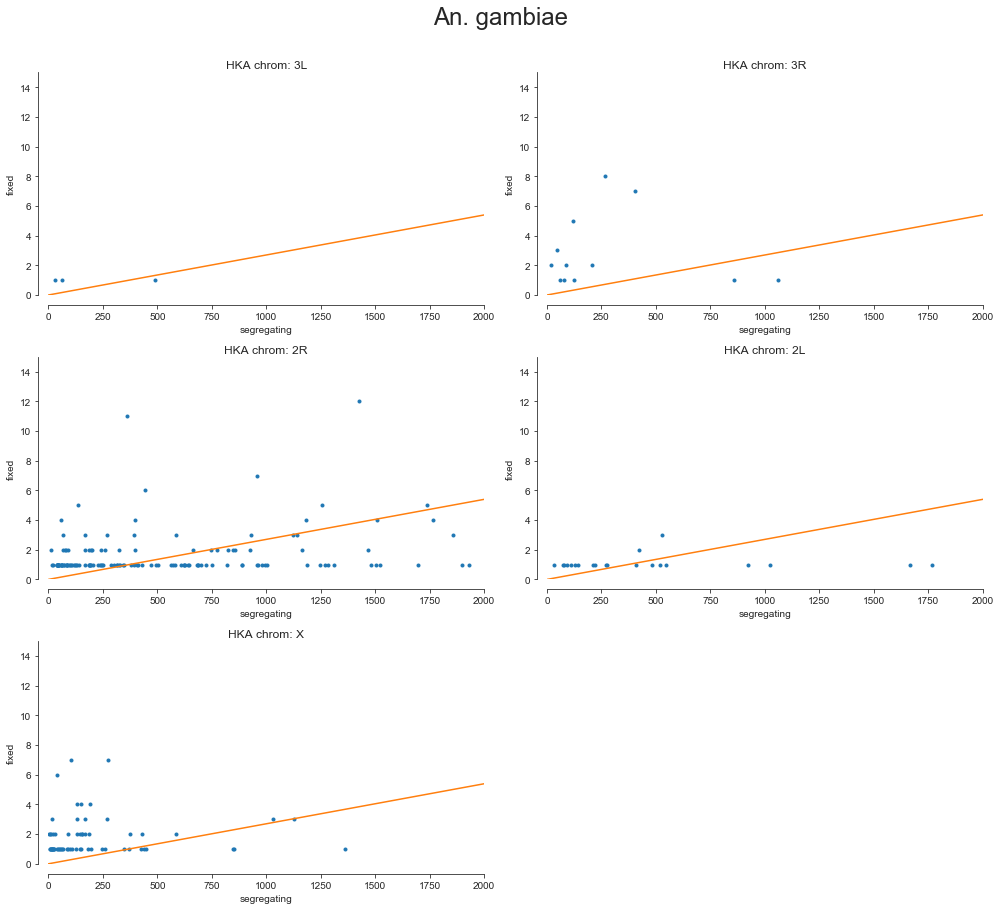

In [79]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, B_geno_wide_gambiae], [0, D_geno_wide_gambiae])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. gambiae', y=1.05, fontsize=24)
fig.tight_layout()

## Plot homogeneity test

In [80]:
# get just the gene matching gambiae coluzzii
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [81]:
joi_gambiae_coluzzii['2L'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP004774,1,148,148.0,1,144,144.0
AGAP004827,4,355,88.75,2,422,211.0
AGAP005165,4,2569,642.25,7,3669,524.1428571428571
AGAP005170,1,982,982.0,1,1766,1766.0
AGAP005245,2,2385,1192.5,2,3102,1551.0


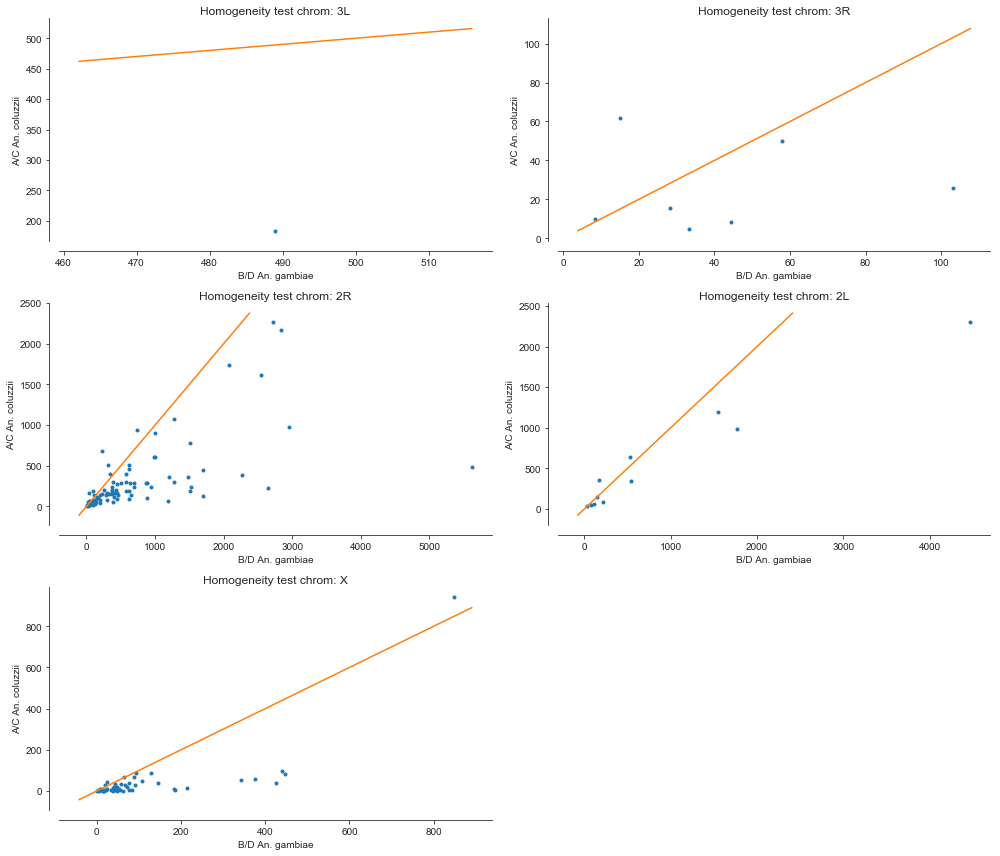

In [82]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    
    AC = joi_gambiae_coluzzii[chrom]['A/C (i.e.seg/fix)'].list()
    BD = joi_gambiae_coluzzii[chrom]['B/D (i.e.seg/fix)'].list()
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(BD, AC, '.')
    lim = max(ax.get_xlim(), ax.get_ylim())
    ax.plot(lim, lim)
    #ax.set_xlim(0,2000)
    #ax.set_ylim(0,2000)
    ax.set_title('Homogeneity test chrom: %s' % chrom)
    ax.set_ylabel('A/C An. coluzzii')
    ax.set_xlabel('B/D An. gambiae')
    sns.set_style('ticks')
    sns.despine(offset=10)

fig.tight_layout()

## Homogeneity test

In [83]:
joi_gambiae_coluzzii[chrom]

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP000519,1,940,940.0,1,848,848.0
AGAP000807,3,293,97.66666666666667,1,441,441.0
AGAP000837,2,102,51.0,1,108,108.0
AGAP000847,14,823,58.785714285714285,3,1128,376.0
AGAP000893,3,100,33.333333333333336,3,130,43.333333333333336


In [84]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [85]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [87]:
with open('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [88]:
homog_tbl = (etl.fromtsv('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP001061,16.1662530519
X,AGAP001052,15.971671742
X,AGAP001073,15.3875978673
X,AGAP013021,8.99706712821
X,AGAP001070,6.91237130528
X,AGAP001093,6.44512942037
X,AGAP001084,4.83885595787
X,AGAP001094,4.81197248691
X,AGAP001043,4.72010752708
X,AGAP001015,4.44649900802


In [89]:
join_hom_direct = homog_tbl.join(direct_select, key='gene')
join_hom_direct.displayall()

chrom,gene,score,chrom,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001061,16.1662530519,X,111,49,inf,272,7,10.4046347998,inf
X,AGAP001084,4.83885595787,X,78,33,237.217222292,103,7,29.1474246401,266.3646469321
X,AGAP001091,2.87882221733,X,32,26,285.90830157,39,6,52.8103551144,338.7186566844
X,AGAP001092,0.0690960723041,X,4,4,40.6238845702,1,2,61.1938695622,101.8177541324
3R,AGAP007732,6.0599263417,3R,92,20,82.8885689414,266,8,14.3278667994,97.2164357408
3R,AGAP007736,2.06033116114,3R,690,45,53.6880742667,1072,38,82.8352794949,136.5233537616


---------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [90]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [91]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP000519,1,940,940.0,1,848,848.0,X
AGAP000807,3,293,97.66666666666667,1,441,441.0,X
AGAP000837,2,102,51.0,1,108,108.0,X
AGAP000847,14,823,58.785714285714285,3,1128,376.0,X
AGAP000893,3,100,33.333333333333336,3,130,43.333333333333336,X


In [92]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP001061,X,16.1662530519
AGAP001052,X,15.971671742
AGAP001073,X,15.3875978673
AGAP013021,X,8.99706712821
AGAP001070,X,6.91237130528
AGAP001093,X,6.44512942037
AGAP007732,3R,6.0599263417
AGAP001084,X,4.83885595787
AGAP001094,X,4.81197248691
AGAP001043,X,4.72010752708


In [93]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP004648,2R,1.37942892022
AGAP004066,2R,0.925949713152
AGAP007762,3R,0.368071455585
AGAP000945,X,0.316223557668
AGAP004774,2L,0.309788613724
AGAP000949,X,0.302031765124
AGAP006748,2L,0.290772591897
AGAP001824,2R,0.288086476906
AGAP000519,X,0.279818442685
AGAP001034,X,0.253969170814


## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)


In [94]:
homogen_select_gambiae.rowlengths()

length,count
3,26


In [95]:
homogen_select_coluzzii.rowlengths()

length,count
3,134


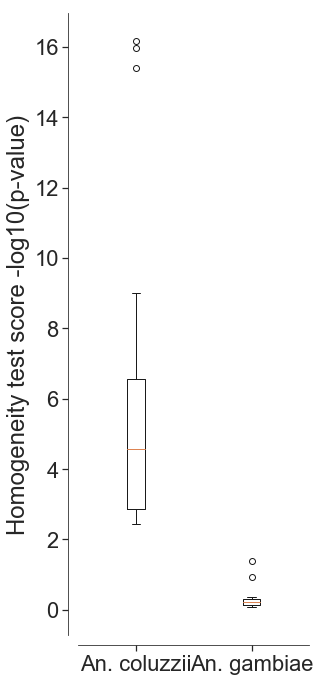

In [96]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

## Plot the distribution of the homogen test genes under private selection

In [97]:
priv_sel_gambiae

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001051,None,None,0,6,2,23.1551537565
2R,AGAP004648,330,2,0.0471918551206,361,11,20.3459727528
2R,AGAP004657,9,1,0.847821958143,13,2,12.4292150686
3R,AGAP007754,None,None,0,120,5,12.0941601313
2R,AGAP001824,2054,15,0.134845692101,3408,32,11.9840660559


In [98]:
private_hom_gambiae = homogen_select_gambiae.join(priv_sel_gambiae, key='gene').sort('score', reverse=True)
private_hom_gambiae.rowlengths()

length,count
10,11


In [99]:
private_hom_coluzzii = homogen_select_coluzzii.join(priv_sel_coluzzii, key='gene').sort('score', reverse=True)
private_hom_coluzzii.rowlengths()

length,count
10,28


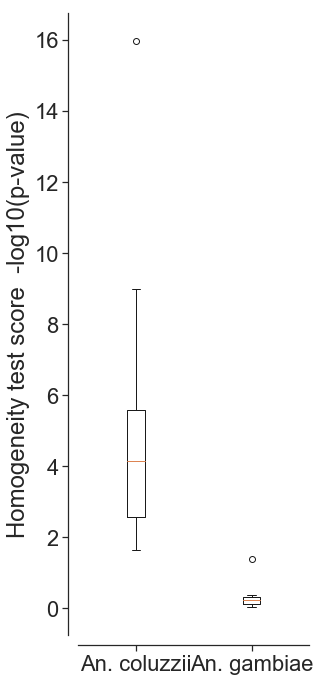

In [100]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = private_hom_gambiae['score'].list()
coluzzii_hom  = private_hom_coluzzii['score'].list()[:11]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score  -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)
fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top11_private_selec_v2.png', dpi=500)

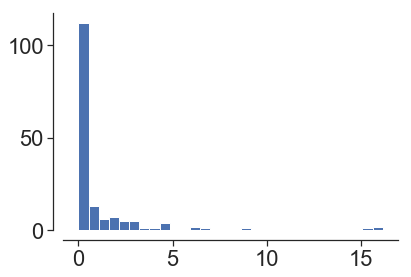

In [101]:
#plot homog score distribution
fig, ax = plt.subplots()
x = [float(i) for i in homog_tbl['score'].list()]
val = ax.hist(x, bins=30)
sns.despine(offset=10)